In [1]:
from configs.default import _C as config
from configs.default import update_config

from datasets import flickr8k_parse
from nltk.translate.bleu_score import corpus_bleu
from scipy import misc

from models import decoder, image_preprocessing, predict, transfer_models

import matplotlib.pyplot as plt
import math
import numpy as np
import os
import path_generation
import text_processing

D:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '

# Evaluation for models built on Flickr8k

In [2]:
train_vocab = text_processing.Vocabulary()
word_to_id_path = os.path.join(config.PATH.VOCABULARY_PATH, config.VOCABULARY.WORD_TO_ID)
id_to_word_path = os.path.join(config.PATH.VOCABULARY_PATH, config.VOCABULARY.ID_TO_WORD)
count_path = os.path.join(config.PATH.VOCABULARY_PATH, config.VOCABULARY.COUNT)
train_vocab.load_vocabulary(word_to_id_path, id_to_word_path, count_path)

In [3]:
path_gen = path_generation.PathGenerator(config.DECODER.GRU, 
                                         config.DATASET, 
                                         config.DECODER.NUM_RNN_LAYERS, 
                                         config.DECODER.BATCH_SIZE, 
                                         config.DECODER.BATCH_NORM, 
                                         config.DECODER.DROPOUT, 
                                         config.ATTENTION, 
                                         config.DECODER.ATTN_TYPE)

path_checkpoint = path_gen.get_weights_path()
model_path = path_gen.get_model_path()
captions_path = path_gen.get_captions_path()

In [4]:
if config.ATTENTION:
    transfer_values = np.load(os.path.join(config.PATH.FEATURES_PATH, 'vgg16_flickr8k_train_attn.npy'))
    val_transfer_values = np.load(os.path.join(config.PATH.FEATURES_PATH, 'vgg16_flickr8k_val_attn.npy'))
else:
    transfer_values = np.load(os.path.join(config.PATH.FEATURES_PATH, 'vgg16_flickr8k_train.npy'))
    val_transfer_values = np.load(os.path.join(config.PATH.FEATURES_PATH, 'vgg16_flickr8k_val.npy'))

In [5]:
decoder_model = decoder.load_model(model_path, path_checkpoint)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
VGG_transfer_model, VGG_image_size = transfer_models.vgg_model(config.ATTENTION)

In [7]:
### beam size might be changed here
beam_size = 1
if config.ATTENTION:
    get_weights = True
else:
    get_weights = False
path = 'D:/Flickr8k/images/240696675_7d05193aa0.jpg'
result = predict.generate_caption(path, 
                                  VGG_image_size, 
                                  decoder_model, 
                                  VGG_transfer_model, 
                                  train_vocab, 
                                  beam_size=beam_size, 
                                  attn=config.ATTENTION, 
                                  get_weights=get_weights)

In [8]:
if get_weights:
    captions, probs, weights = result
else:
    captions, probs = result
best_caption = captions[0]

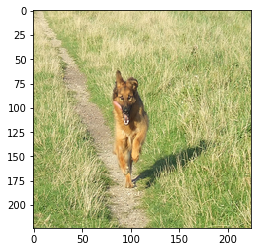

a black dog is running through the grass -0.486


In [9]:
img = image_preprocessing.image_preprocessing(path, VGG_image_size)
plt.imshow(img)
plt.show()
for i in range(len(captions)):
    print(" ".join(captions[i]),
          "{:.3f}".format(probs[i]))

In [10]:
if get_weights:
    cols = 4
    rows = math.ceil(len(best_caption) / cols)
    plt.figure(1, figsize=(12,12))
    for word_num in range(len(best_caption)):
        weights_img = np.reshape(weights[word_num], [14,14])
        weights_img = misc.imresize(weights_img, (224, 224))
        img = image_preprocessing.image_preprocessing(path, (224,224))
        plt.subplot(rows, cols, word_num + 1)
        plt.title(best_caption[word_num], fontsize=20)
        plt.imshow(img)
        plt.imshow(weights_img, cmap='bone', alpha=0.8)
        plt.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.savefig('./test.png')
    plt.show()

In [11]:
captions_file = os.path.join(config.PATH.ANNOTATIONS_PATH, "Flickr8k.token.txt")
test_txt_path = os.path.join(config.PATH.ANNOTATIONS_PATH, "Flickr_8k.testImages.txt")

filenames_with_all_captions = flickr8k_parse.generate_filenames_with_all_captions(captions_file, config.PATH.IMG_PATH)

test_filenames_with_all_captions = flickr8k_parse.generate_set(test_txt_path, 
                                                               filenames_with_all_captions, 
                                                               config.PATH.IMG_PATH)

test_captions = flickr8k_parse.make_list_of_captions(test_filenames_with_all_captions)

In [12]:
text_processing.preprocess_captions(test_captions)

In [13]:
references = []
for list_captions in test_captions:
    reference = []
    for caption in list_captions:
        reference.append(caption.split())
    references.append(reference)

In [14]:
references[0]

[['the',
  'dogs',
  'are',
  'in',
  'the',
  'snow',
  'in',
  'front',
  'of',
  'a',
  'fence'],
 ['the', 'dogs', 'play', 'on', 'the', 'snow'],
 ['two', 'brown', 'dogs', 'playfully', 'fight', 'in', 'the', 'snow'],
 ['two', 'brown', 'dogs', 'wrestle', 'in', 'the', 'snow'],
 ['two', 'dogs', 'playing', 'in', 'the', 'snow']]

In [15]:
if config.ATTENTION:
    transfer_values = np.load('./cnn_features/vgg16_flickr8k_test_attn.npy')
else:
    transfer_values = np.load('./cnn_features/vgg16_flickr8k_test.npy')

In [16]:
use_transfer_values = True
generated_captions = predict.generate_test_captions(transfer_values, 
                                                    VGG_image_size, 
                                                    decoder_model, 
                                                    VGG_transfer_model, 
                                                    train_vocab, 
                                                    use_transfer_values, 
                                                    beam_size,
                                                    config.DECODER.MAX_LEN,
                                                    config.ATTENTION, 
                                                    False)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [17]:
with open(captions_path, 'w') as captions_file:
    for caption in generated_captions:
        captions_file.write(" ".join(caption))
        captions_file.write("\n")

In [18]:
print('BLEU-1 Score on test data: {:.3f}'.format(corpus_bleu(references, generated_captions, weights=(1,0,0,0)) * 100))

BLEU-1 Score on test data: 52.227


In [19]:
print('BLEU-2 Score on test data: {:.3f}'.format(corpus_bleu(references, generated_captions, weights=(0.5,0.5)) * 100))

BLEU-2 Score on test data: 33.021


In [20]:
print('BLEU-3 Score on test data: {:.3f}'.format(corpus_bleu(references, generated_captions, weights=(0.33,0.33,0.33,0)) * 100))

BLEU-3 Score on test data: 20.914


In [21]:
print('BLEU-4 Score on test data: {:.3f}'.format(corpus_bleu(references, generated_captions, weights=(0.25,0.25,0.25,0.25)) * 100))

BLEU-4 Score on test data: 12.972
